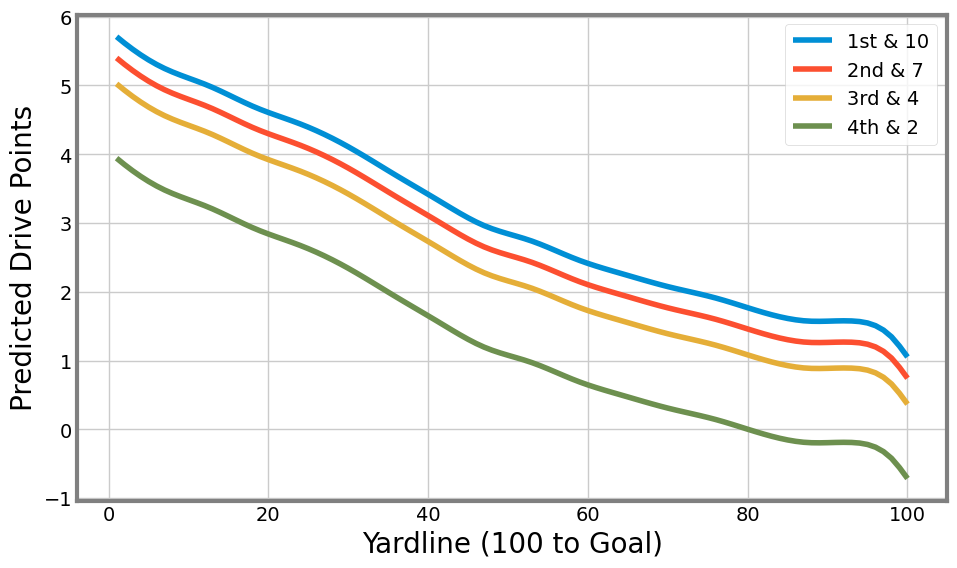

In [1]:
import joblib
from pygam import LinearGAM, s, f, te
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

gam = joblib.load('/Users/lukeneuendorf/projects/nfl-big-data-bowl-2026/data/models/gam_drive_points_model.pkl')

down_mapping = {1: '1st', 2: '2nd', 3: '3rd', 4: '4th'}
plt.style.use('fivethirtyeight')
# set background to white
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
# and plot bourder to white
plt.rcParams['axes.edgecolor'] = 'gray'
plt.figure(figsize=(10,6))
for down, ydstogo in [(1,10),(2,7),(3,4),(4,2)]:
    pred_y = []
    yardline_vals = range(1,101)
    for yl in yardline_vals:
        features = np.array([[yl, 900, down, ydstogo, 2, 2]])
        pred_y.append(gam.predict(features)[0])
    plt.plot(yardline_vals, pred_y, label=f'{down_mapping[down]} & {ydstogo}')
plt.xlabel("Yardline (100 to Goal)", color='black', fontsize=20 )
plt.ylabel("Predicted Drive Points", color='black', fontsize=20 )
# plt.title("Predicted Drive Points")
plt.legend()
plt.grid(True)
plt.show()

In [2]:
import logging
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from tqdm import tqdm

sys.path.append('../py')
from preprocess import preprocess

LOG = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

RANDOM_SEED = 2
np.random.seed(RANDOM_SEED)

N_WEEKS = 18

In [3]:
##############  i. Load and preprocess the data ##############
sup_data = pd.read_csv('../data/supplementary_data.csv')
tracking_input, tracking_output = pd.DataFrame(), pd.DataFrame()
for week in tqdm(range(1, N_WEEKS+1), desc="Loading weekly data"):
    tracking_input = pd.concat([tracking_input, pd.read_csv(f'../data/train/input_2023_w{week:02d}.csv')], axis=0)
    tracking_output = pd.concat([tracking_output, pd.read_csv(f'../data/train/output_2023_w{week:02d}.csv')], axis=0)
LOG.info(f'Tracking input shape: {tracking_input.shape}, output shape: {tracking_output.shape}')

games, plays, players, tracking = preprocess.process_data(tracking_input, tracking_output, sup_data)
team_desc = preprocess.fetch_team_desc()

Loading weekly data: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]
2025-12-14 22:50:35,569 - INFO - Tracking input shape: (4880579, 23), output shape: (562936, 6)
2025-12-14 22:50:42,671 - INFO - Joined input and output tracking data: 14108 unique plays, 1384 unique nfl_ids
2025-12-14 22:50:42,671 - INFO - Standardizing direction of play and players to be left to right
2025-12-14 22:50:43,857 - INFO - Approximating missing speed, acceleration and direction values
2025-12-14 22:50:46,371 - INFO - Correlation results for imputations: s_approx: speed R²=0.9897 | a_approx: accel R²=0.0445 | dir_approx: dir R²=0.0442
2025-12-14 22:50:46,974 - INFO - Joining supplemental data to plays DataFrame
2025-12-14 22:50:47,006 - INFO - Loading NFL PBP data for season 2023
2025-12-14 22:50:47,006 - INFO - Loading pbp from local parquet file
2025-12-14 22:50:47,159 - INFO - Mapping player IDs to nfl_id using seasonal rosters
2025-12-14 22:50:47,159 - INFO - Rosters for season 2023 already cached, loa

In [4]:
cmp_results = (
    pd.read_parquet('../data/results/cmp_preds.parquet')
    .merge(
        plays[['gpid', 'absolute_yardline_number', 'ball_land_x', 'ball_land_y','num_frames_output']],
        on='gpid', how='left')
    .assign(
        x=lambda x: x['absolute_yardline_number'] + x['x'],
        start_x=lambda x: x['absolute_yardline_number'] + x['start_x'],
    )
)
cmp_results.head()

,gpid,safety_nfl_id,sample_type,x,y,vx,vy,start_x,start_y,start_dir,start_s,predicted_cmp,absolute_yardline_number,ball_land_x,ball_land_y,num_frames_output
0,2023090700_101,46137,original,62.870000,4.630000,2.600729,-7.501987,53.08,20.04,326.31,2.59,0.023005,42,63.259998,-0.22,21
1,2023090700_101,46137,simulated,72.955746,15.432903,6.819203,-1.580656,53.08,20.04,326.31,2.59,0.536439,42,63.259998,-0.22,21
2,2023090700_101,46137,simulated,73.159746,16.682307,6.904139,-1.154496,53.08,20.04,326.31,2.59,0.541462,42,63.259998,-0.22,21
3,2023090700_101,46137,simulated,73.280823,17.979474,6.963866,-0.710329,53.08,20.04,326.31,2.59,0.545873,42,63.259998,-0.22,21
4,2023090700_101,46137,simulated,73.310887,19.321168,6.995585,-0.248563,53.08,20.04,326.31,2.59,0.549383,42,63.259998,-0.22,21


In [5]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull
from matplotlib.path import Path
import pandas as pd

def plot_safety_reach_heatmap(df, model_type="epa", tracking=None, buffer_yards=10):
    """
    Heatmap of predicted EPA / INT / CMP over safety reach,
    with full player context and ball trajectory on a football field background.
    """
    
    # -----------------------------
    # Prediction config
    # -----------------------------
    pred_map = {
        "epa": ("predicted_epa", "RdYlGn_r", "Predicted EPA"),
        "int": ("predicted_int", "coolwarm", "Predicted INT Probability"),
        "cmp": ("predicted_cmp", "viridis", "Predicted Completion Probability"),
    }

    if model_type not in pred_map:
        raise ValueError("model_type must be 'epa', 'int', or 'cmp'")

    pred_col, cmap, cbar_label = pred_map[model_type]

    # -----------------------------
    # Filter to safety
    # -----------------------------
    safety_nfl_id = df["safety_nfl_id"].iloc[0]
    gpid = df["gpid"].iloc[0]
    df = df.query("safety_nfl_id == @safety_nfl_id")

    # Safety start
    start_x = df["start_x"].iloc[0]
    start_y = df["start_y"].iloc[0]
    start_dir = np.deg2rad(df["start_dir"].iloc[0])
    start_speed = df["start_s"].iloc[0]
    start_dx = np.cos(start_dir) * start_speed * 0.5
    start_dy = np.sin(start_dir) * start_speed * 0.5

    # Safety final (actual)
    original = df.query("sample_type == 'original'").iloc[0]
    end_x, end_y = original["x"], original["y"]
    end_dx = original["vx"] * 0.5
    end_dy = original["vy"] * 0.5

    # -----------------------------
    # Simulated surface
    # -----------------------------
    sim = df.query("sample_type == 'simulated'")
    xs, ys = sim["x"].values, sim["y"].values
    preds = sim[pred_col].values

    # Determine plot bounds based on all relevant data
    all_x = []
    all_y = []
    
    # Add safety start and end points
    all_x.extend([start_x, end_x])
    all_y.extend([start_y, end_y])
    
    # Add simulated surface points
    all_x.extend(xs)
    all_y.extend(ys)
    
    # Add ball landing point
    ball_x, ball_y = df["ball_land_x"].iloc[0], df["ball_land_y"].iloc[0]
    all_x.append(ball_x)
    all_y.append(ball_y)
    
    # Add players from tracking if available
    if tracking is not None:
        last_frame = tracking.query("gpid == @gpid").frame_id.max()
        frame = tracking.query("gpid == @gpid & frame_id == @last_frame")
        all_x.extend(frame['x'].values)
        all_y.extend(frame['y'].values)
    
    # Calculate bounds with buffer
    min_x = max(0, min(all_x) - buffer_yards)
    max_x = min(120, max(all_x) + buffer_yards)
    min_y = max(0, min(all_y) - 5)  # Smaller buffer for y (field is narrower)
    max_y = min(53.3, max(all_y) + 5)
    
    # Create grid for heatmap within bounds
    xi = np.linspace(min_x, max_x, 200)
    yi = np.linspace(min_y, max_y, 200)
    xi_grid, yi_grid = np.meshgrid(xi, yi)

    zi_grid = griddata(
        (xs, ys), preds,
        (xi_grid, yi_grid),
        method="cubic", fill_value=np.nan
    )

    # Convex hull mask
    hull = ConvexHull(np.column_stack((xs, ys)))
    hull_path = Path(np.column_stack((xs, ys))[hull.vertices])
    mask = hull_path.contains_points(
        np.column_stack((xi_grid.ravel(), yi_grid.ravel()))
    ).reshape(xi_grid.shape)
    zi_grid[~mask] = np.nan

    # -----------------------------
    # Set up field plot
    # -----------------------------
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Set axis limits
    ax.set_xlim(min_x - 0.1, max_x + 0.1)
    ax.set_ylim(min_y - 0.1, max_y + 0.1)
    
    # Remove axis elements
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # -----------------------------
    # Plot field markings
    # -----------------------------
    # Add yard lines within bounds
    for yard_line in range(int(np.ceil(min_x)), int(np.floor(max_x)) + 1):
        if yard_line % 5 == 0 and yard_line >= 0 and yard_line <= 120:
            ax.axvline(x=yard_line, color='gray', linestyle='-', alpha=0.3, zorder=1)
    
    # Add hash marks
    hash_width = 0.33
    hash_y_positions = [
        hash_width,
        ((53.3/2 * 3) - (18.5 / 2)) / 3 - hash_width, 
        ((53.3/2 * 3) + (18.5 / 2)) / 3 + hash_width,
        53.3 - hash_width
    ]
    
    for yard_line in range(int(np.ceil(min_x)), int(np.floor(max_x)) + 1):
        if yard_line % 5 != 0 and yard_line >= 10 and yard_line <= 110:
            for hash_y in hash_y_positions:
                if min_y <= hash_y <= max_y:
                    ax.plot([yard_line, yard_line], 
                           [hash_y - hash_width, hash_y + hash_width], 
                           color='gray', linestyle='-', alpha=0.5, linewidth=1, zorder=1)
    
    # Add yardline numbers if they fall within bounds
    yardline_x_positions = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    for x_pos in yardline_x_positions:
        if min_x <= x_pos <= max_x:
            # Determine yard number
            if x_pos <= 50:
                yard_num = x_pos
            else:
                yard_num = 100 - x_pos
            
            # Bottom number
            if min_y <= 12 <= max_y:
                ax.text(x_pos, 12, str(yard_num),
                       ha='center', va='center',
                       fontsize=12, fontweight='bold', color='gray', zorder=1)
            
            # Top number (rotated 180 degrees)
            if min_y <= (53.3 - 12) <= max_y:
                ax.text(x_pos, 53.3 - 12, str(yard_num),
                       ha='center', va='center',
                       fontsize=12, fontweight='bold', rotation=180, color='gray', zorder=1)
    
    # Add line of scrimmage if it falls within bounds
    los_x = df["absolute_yardline_number"].iloc[0]
    if min_x <= los_x <= max_x:
        ax.axvline(x=los_x, color='blue', linestyle='-', alpha=0.6, linewidth=2, zorder=2, label="Line of Scrimmage")
    
    # -----------------------------
    # Plot heatmap surface
    # -----------------------------
    im = ax.contourf(
        xi_grid, yi_grid, zi_grid,
        levels=40, cmap=cmap, alpha=0.7, zorder=2
    )
    ax.contour(
        xi_grid, yi_grid, zi_grid,
        levels=10, linewidths=0.6, alpha=0.3, zorder=3
    )
    
    # -----------------------------
    # Plot safety start + vectors
    # -----------------------------
    ax.scatter(start_x, start_y, s=100, color="darkgray",
              edgecolors="black", linewidths=2,
              label="Safety Start", zorder=6)
    
    ax.arrow(start_x, start_y, start_dx, start_dy,
            head_width=0.5, head_length=0.8,
            fc="black", ec="black", zorder=6)
    
    # Safety final + vector
    ax.scatter(end_x, end_y, s=100, color="black",
              edgecolors="black", linewidths=2,
              label="Safety Final", zorder=7)
    
    ax.arrow(end_x, end_y, end_dx, end_dy,
            head_width=0.5, head_length=0.8,
            fc="black", ec="black", zorder=7)
    
    # -----------------------------
    # Plot ball: start, landing, path
    # -----------------------------
    ball_x, ball_y = df["ball_land_x"].iloc[0], df["ball_land_y"].iloc[0]
    
    if tracking is not None:
        ball_start_frame = tracking.query(
            "gpid == @gpid & ~pass_thrown"
        ).frame_id.max()
        
        ball_start = tracking.query(
            "gpid == @gpid & frame_id == @ball_start_frame & player_side == 'Ball'"
        )
        
        if not ball_start.empty:
            bsx, bsy = ball_start.x.values[0], ball_start.y.values[0]
            
            ax.scatter(bsx, bsy, marker="x", s=150,
                      color="brown", label="Ball Start", zorder=8, linewidths=2)
            
            ax.plot([bsx, ball_x], [bsy, ball_y],
                   linestyle="--", color="brown", linewidth=2,
                   label="Ball Path", zorder=1)
    
    ax.scatter(ball_x, ball_y, marker="x", s=150,
              color="red", label="Ball Landing", zorder=8, linewidths=2)
    
    # -----------------------------
    # Plot players + vectors (last frame)
    # -----------------------------
    if tracking is not None:
        last_frame = tracking.query("gpid == @gpid").frame_id.max()
        frame = tracking.query("gpid == @gpid & frame_id == @last_frame")
        
        defenders = frame.query(
            "player_side == 'Defense' & nfl_id != @safety_nfl_id"
        )
        offense = frame.query("player_side == 'Offense'")
        
        # Constant colors
        ax.scatter(defenders.x, defenders.y, s=80,
                  color="orange", edgecolors="black", linewidths=2,
                  label="Other Defenders", zorder=6)
        
        ax.scatter(offense.x, offense.y, s=80,
                  color="cyan", edgecolors="black", linewidths=2,
                  label="Receivers / Offense", zorder=6)
        
        # Add player positions as text
        for _, row in defenders.iterrows():
            if 'position' in row:
                ax.text(row['x'] + 0.1, row['y'] - 0.1, row['position'],
                       color='black', fontsize=8, ha='center', va='center',
                       fontweight='bold', zorder=7,
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
        
        for _, row in offense.iterrows():
            if 'position' in row:
                ax.text(row['x'] + 0.1, row['y'] - 0.1, row['position'],
                       color='black', fontsize=8, ha='center', va='center',
                       fontweight='bold', zorder=7,
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
        
        # Add direction arrows for all players
        for _, row in pd.concat([defenders, offense]).iterrows():
            rad = np.deg2rad(row["dir"])
            ax.arrow(
                row["x"], row["y"],
                np.cos(rad) * row["s"] * 0.5,
                np.sin(rad) * row["s"] * 0.5,
                head_width=0.4, head_length=0.6,
                fc="black", ec="black", zorder=7, alpha=0.8
            )
    
    # -----------------------------
    # Final touches
    # -----------------------------
    # Add title
    safety_name = df["safety_display_name"].iloc[0] if "safety_display_name" in df.columns else f"Safety {safety_nfl_id}"
    ax.set_title(f"Safety Reach Analysis: {safety_name}\n"
                f"Play {gpid} - {cbar_label}", fontsize=14, fontweight='bold', pad=20)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label(cbar_label, fontsize=12)
    
    # Add legend (outside plot)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()

(:45) (No Huddle, Shotgun) P.Mahomes pass deep left to Ju.Watson pushed ob at DET 4 for 26 yards (C.Gardner-Johnson).


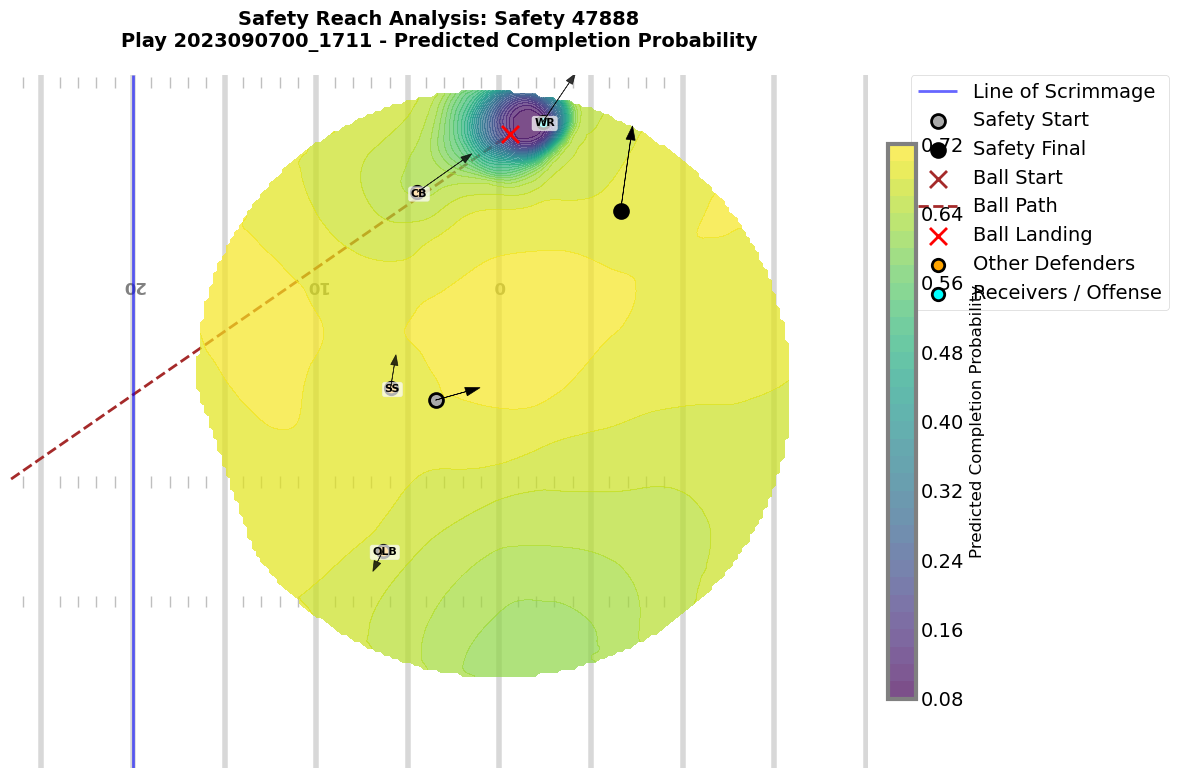

In [6]:
gpid = cmp_results['gpid'].unique()[5]
ex_df = cmp_results[cmp_results['gpid'] == gpid]
print(plays.query("gpid == @gpid").play_description.values[0])
plot_safety_reach_heatmap(ex_df, model_type="cmp", tracking=tracking, buffer_yards=10)

In [17]:
from typing import Dict
import textwrap
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patheffects as pe
import pandas as pd
import numpy as np
from IPython.display import HTML
from matplotlib.patches import FancyArrowPatch

def animate_play(
    tracking_play: pd.DataFrame, 
    play: pd.DataFrame,
    game: pd.DataFrame,
    team_desc: pd.DataFrame,
    save_path: str = None,
    plot_positions: bool = False,
    highlight_postpass_players:bool = False,
    show_postpass_paths: bool = False,
    plot_arrows: bool = False,  # New parameter to enable arrows
    show_ball_trajectory: bool = True
):
    """Animate a single play from tracking data.

    Args:
        tracking_play: DataFrame containing tracking data for a single play (single gpid).
        play: DataFrame containing the play level data for a single play.
        game: Optional DataFrame containing game level data for a single game.
        team_desc: DataFrame containing team descriptions (abbreviations, full names, logos, etc).
        save_path: Optional path to save the animation as a video file. If None, the 
            animation is displayed inline.
        plot_positions: If True, player positions (e.g., WR, QB) will be annotated over 
            the players.
        highlight_postpass_players: If True, players involved in the pass after the ball
            is thrown will be highlighted.
        show_postpass_paths: If True, dashed lines will be drawn showing the paths of
            players involved in the pass after the ball is thrown.
        plot_arrows: If True, arrows will be drawn to indicate the direction of movement
            for players and the ball.

    Returns:
        If save_path is None, returns an HTML object containing the animation.
    """
    if tracking_play['gpid'].nunique() != 1:
        raise ValueError("Tracking DataFrame must contain only one unique play (gpid).")
    if play['gpid'].nunique() != 1:
        raise ValueError("Play DataFrame must contain only one unique play (gpid).")
    if game is not None and game['game_id'].nunique() != 1:
        raise ValueError("Game DataFrame must contain only one unique game (gpid).")

    tracking_play = tracking_play.sort_values(by='frame_id')

    # Calculate x-axis limits based on play data
    all_x = tracking_play['x'].dropna()
    min_x = all_x.min()
    max_x = all_x.max()
    x_range = max_x - min_x
    
    # Ensure at least 50 yards of width, plus 2 yard buffer on each side
    if x_range < 50:
        center_x = (min_x + max_x) / 2
        min_x = center_x - 25 - 2  # 25 yards on each side plus buffer
        max_x = center_x + 25 + 2
    else:
        min_x = min_x - 2  # Add 2 yard buffer
        max_x = max_x + 2  # Add 2 yard buffer

    min_x = 0 if min_x < 10 else min_x
    max_x = 120 if max_x > 110 else max_x
    
    # Ensure bounds are within reasonable field limits
    min_x = max(0, min_x)
    max_x = min(120, max_x)

    # --- Plot setup ---
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_xlim(min_x-.1, max_x+.1)
    ax.set_ylim(-0.1, 53.4)  # Field width becomes y-axis
    # ax.set_aspect('equal') # Equal aspect ratio between x and y axes
    
    # Remove axis elements
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_ylabel('')  # Remove y-axis label
    
    # Remove the axis spine/border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
        
    # Add vertical yard lines every 5 yards on the x-axis
    # for yard_line in range(max(int(np.ceil(min_x)), 10), min(int(np.floor(max_x)), 110) + 1):
    #     if yard_line % 5 == 0:  # Every 5 yards
    #         ax.axvline(x=yard_line, color='gray', linestyle='-', alpha=0.5, zorder=1)

    # Add horizontal lines at top and bottom of the field
    # ax.axhline(y=0, color='grey', linestyle='-', alpha=.5, zorder=1)
    # ax.axhline(y=53.3, color='grey', linestyle='-', alpha=.5, zorder=1)

    # Add vertical lines at ends of field
    # ax.axvline(x=0, color='grey', linestyle='-', alpha=.5, zorder=1)
    # ax.axvline(x=120, color='grey', linestyle='-', alpha=.5, zorder=1)
    
    # ax = _plot_yardline_numbers(ax, min_x, max_x)

    # NFL hash marks (18'6" apart on inner edges)
    hash_width = .33
    hash_y_positions = [
        hash_width,
        ((53.3/2 * 3) - (18.5 / 2)) / 3 - hash_width, 
        ((53.3/2 * 3) + (18.5 / 2)) / 3 + hash_width,
        53.3 - hash_width
    ]
    # for yard_line in range(max(int(np.ceil(min_x)), 10), min(int(np.floor(max_x)), 110) + 1):
    #     # Only draw hash marks for yards not divisible by 5
    #     if yard_line % 5 != 0:
    #         # Draw hash marks at both hash positions
    #         for hash_y in hash_y_positions:
    #             ax.plot([yard_line, yard_line], [hash_y - hash_width, hash_y + hash_width], 
    #                 color='gray', linestyle='-', alpha=0.7, linewidth=1, zorder=1)
                
    # Plot the line of scrimmage
    los_x = play['absolute_yardline_number'].values[0]
    # ax.axvline(x=los_x, color='blue', linestyle='-', alpha=0.8, linewidth=2, zorder=2)

    # Plot the first down line
    ytg = play['yards_to_go'].values[0]
    # ax.axvline(x=los_x + ytg, color='yellow', linestyle='-', alpha=0.8, linewidth=2, zorder=2)

    # Colors by side
    def is_color_darker(color1, color2):
        color_brightness = {
            'black': 0, 'navy': 10, 'blue': 50, 'green': 50, 'red': 100,
            'purple': 60, 'gold': 200, 'yellow': 220, 'white': 255,
            'brown': 80, 'orange': 180, 'gray': 128
        }
        
        brightness1 = color_brightness.get(color1.lower(), 128)
        brightness2 = color_brightness.get(color2.lower(), 128)
        
        return brightness1 < brightness2

    offense = play.possession_team.values[0]
    home_team_is_offense = game.home_team_abbr.values[0] == offense
    offense_c1 = team_desc.query('team_abbr == @offense').team_color.values[0]
    offense_c2 = team_desc.query('team_abbr == @offense').team_color2.values[0]
    if is_color_darker(offense_c1, offense_c2):
        off_main, off_edge = offense_c1, offense_c2
    else:
        off_main, off_edge = offense_c2, offense_c1

    defense = play.defensive_team.values[0]
    defense_c1 = team_desc.query('team_abbr == @defense').team_color.values[0]
    defense_c2 = team_desc.query('team_abbr == @defense').team_color2.values[0]
    if is_color_darker(defense_c1, defense_c2):
        def_main, def_edge = defense_c1, defense_c2
    else:
        def_main, def_edge = defense_c2, defense_c1

    main_color_map = {
        'Offense': off_edge,
        'Defense': def_edge,
        'Ball': 'brown'
    }
    edge_color_map = {
        'Offense': off_main, 
        'Defense': def_main,
        'Ball': 'black'
    }
    
    # Group by frame for animation
    frames = tracking_play.groupby('frame_id')

    if plot_positions:
        marker_size=12
    else:
        marker_size=8
    
    # Set up scatter plot placeholders for all three groups
    scat_off = ax.scatter([], [], s=marker_size**2, c=main_color_map['Offense'],
                      edgecolors=edge_color_map['Offense'], linewidths=2,
                      label='Offense', alpha=0.7, zorder=3)
    scat_def = ax.scatter([], [], s=marker_size**2, c=main_color_map['Defense'],
                        edgecolors=edge_color_map['Defense'], linewidths=2,
                        label='Defense', alpha=0.7, zorder=3)
    scat_ball = ax.scatter([], [], s=6**2, c=main_color_map['Ball'],
                        edgecolors=edge_color_map['Ball'], linewidths=1,
                        label='Ball', alpha=1.0, zorder=5)
    
    # Dashed trajectory line for the ball (initially empty)
    (ball_path_line,) = ax.plot([], [], linestyle='--', color='brown', linewidth=2,
                            alpha=0.8, zorder=3)
    
    ax.legend(
        loc='center left',
        bbox_to_anchor=(.93, 1.085),
    )

    home_colors = {
        'c1': offense_c1 if home_team_is_offense else defense_c1,
        'c2': offense_c2 if home_team_is_offense else defense_c1,
    }
    away_colors = {
        'c1': defense_c1 if home_team_is_offense else offense_c1,
        'c2': defense_c2 if home_team_is_offense else offense_c2,
    }

    ax = _add_game_info_text(ax, play, game, home_colors, away_colors)

    if min_x < 10:
        # plot the defense team endzone
        ax.add_patch(plt.Rectangle((0, 0), 10, 53.3, color='grey', alpha=0.1, zorder=0))
        ax.text(
            5, 53.3/2, team_desc.query('team_abbr == @defense').team_nick.values[0].upper(),
            fontsize=60, fontweight='bold', alpha=.5, #style='italic',
            rotation=90, ha='center', va='center', zorder=1,
            color=defense_c1,
            path_effects=[pe.withStroke(linewidth=7, foreground=defense_c2)]  # Outline
        )
    if max_x > 110:
        # plot the offense team endzone
        ax.add_patch(plt.Rectangle((110, 0), 10, 53.3, color='grey', alpha=0.1, zorder=0))
        ax.text(
            115, 53.3/2, team_desc.query('team_abbr == @offense').team_nick.values[0].upper(),
            fontsize=60, fontweight='bold', alpha=.5, #style='italic',
            rotation=-90, ha='center', va='center', zorder=1,
            color=offense_c1, 
            path_effects=[pe.withStroke(linewidth=7, foreground=offense_c2)]  # Outline
        )

    position_texts = []
    player_path_lines = {}  # For post-pass paths
    arrows = []  # For movement arrows

    def update(frame_tuple):
        frame_id, frame_data = frame_tuple

        off_data = frame_data[frame_data['player_side'] == 'Offense']
        def_data = frame_data[frame_data['player_side'] == 'Defense']
        ball_data = frame_data[frame_data['player_side'] == 'Ball']

        scat_off.set_offsets(off_data[['x', 'y']].values)
        scat_def.set_offsets(def_data[['x', 'y']].values)
        scat_ball.set_offsets(ball_data[['x', 'y']].values)

        # Plot dashed ball trajectory starting at pass_thrown
        current_frame_id = frame_id
        thrown_frames = tracking_play[
            (tracking_play['frame_id'] <= current_frame_id)
            & (tracking_play['pass_thrown'] == True)
            & (tracking_play['player_side'] == 'Ball')
        ]

        # Update the dashed trajectory line
        if not thrown_frames.empty and show_ball_trajectory:
            ball_path_line.set_data(thrown_frames['x'].values, thrown_frames['y'].values)
        else:
            ball_path_line.set_data([], [])

        # --- Highlight post-pass players ---
        if highlight_postpass_players:
            # Determine if pass has been thrown yet
            pass_has_been_thrown = any(tracking_play['frame_id'] <= current_frame_id)
            if pass_has_been_thrown and (tracking_play['pass_thrown'].any()):
                postpass_players = frame_data[frame_data['player_to_predict'] == True]
                if not postpass_players.empty:
                    # Highlight on offense and defense separately
                    off_colors = ['red' if pid in postpass_players['nfl_id'].values else 
                                  edge_color_map['Offense'] for pid in off_data['nfl_id'].values]
                    def_colors = ['red' if pid in postpass_players['nfl_id'].values else 
                                    edge_color_map['Defense'] for pid in def_data['nfl_id'].values]
                    scat_off.set_edgecolors(off_colors)
                    scat_off.set_linewidths([3 if c == 'red' else 2 for c in off_colors])
                    scat_def.set_edgecolors(def_colors)
                    scat_def.set_linewidths([3 if c == 'red' else 2 for c in def_colors])
        else:
            # Reset edge colors to default if highlighting off
            scat_off.set_edgecolors(edge_color_map['Offense'])
            scat_def.set_edgecolors(edge_color_map['Defense'])
            scat_off.set_linewidths(2)
            scat_def.set_linewidths(2)

        # --- Post-pass player paths ---
        if show_postpass_paths:
            # Get player_to_predict IDs
            predicted_ids = tracking_play.loc[tracking_play['player_to_predict'] == True, 'nfl_id'].unique()

            for pid in predicted_ids:
                player_frames = tracking_play[
                    (tracking_play['nfl_id'] == pid)
                    & (tracking_play['pass_thrown'] == True)
                    & (tracking_play['frame_id'] <= current_frame_id)
                ]

                # Only plot if pass has been thrown and there are frames
                if not player_frames.empty:
                    if pid not in player_path_lines:
                        # Create a new dashed line for this player
                        line, = ax.plot([], [], '--', color='black', linewidth=2, alpha=0.8, zorder=2)
                        player_path_lines[pid] = line
                    player_path_lines[pid].set_data(player_frames['x'].values, player_frames['y'].values)
                elif pid in player_path_lines:
                    # Clear line if not yet thrown
                    player_path_lines[pid].set_data([], [])
        else:
            # Remove all player path lines if disabled
            for line in player_path_lines.values():
                line.set_data([], [])

        # --- Positions text ---
        for txt in position_texts:
            txt.remove()
        position_texts.clear()
        if plot_positions:
            for _, row in off_data.iterrows():
                t = ax.text(
                    row['x'] + 0.05, row['y'] - 0.05, row['position'],
                    color='black', fontsize=6, ha='center', va='center',
                    fontweight='bold', zorder=4
                )
                position_texts.append(t)
            for _, row in def_data.iterrows():
                t = ax.text(
                    row['x'] + 0.05, row['y'] - 0.05, row['position'],
                    color='black', fontsize=6, ha='center', va='center',
                    fontweight='bold', zorder=4
                )
                position_texts.append(t)

        
        # --- Plot arrows for movement ---
        if plot_arrows:
            # Remove previous arrows
            for arrow in arrows:
                arrow.remove()
            arrows.clear()

            # Add new arrows for each player and the ball
            for _, row in frame_data.iterrows():
                x, y = row['x'], row['y']
                length = 3.0 
                angle_rad = np.radians(row['dir'])

                dx = length * np.cos(angle_rad)
                dy = length * np.sin(angle_rad)

                arrow = FancyArrowPatch(
                    posA=(x, y),
                    posB=(x + dx, y + dy),
                    arrowstyle='-|>', color='grey', mutation_scale=15, linewidth=2, zorder=3
                )
                ax.add_patch(arrow)
                arrows.append(arrow)

        # Collect all active artists
        animated_artists = [scat_off, scat_def, scat_ball, ball_path_line, *position_texts, *arrows]
        animated_artists.extend(player_path_lines.values())

        return animated_artists


    # Create animation
    ani = animation.FuncAnimation(
        fig, update, frames=frames, blit=False, interval=80, repeat=False
    )

    if save_path:
        try:
            ani.save(save_path, writer='ffmpeg', fps=12, dpi=100)
            plt.close(fig)
            print(f"Animation saved to {save_path}")
        except Exception as e:
            print(f"Error saving animation: {e}")
            # Fallback to HTML display
            plt.close(fig)
            return HTML(ani.to_jshtml())
    else:
        plt.close(fig)
        return HTML(ani.to_jshtml())
    
def _plot_yardline_numbers(ax, min_x, max_x) -> plt.Axes:
    yardline_positions = [10, 20, 30, 40, 50, 40, 30, 20, 10]
    yardline_x_positions = [20, 30, 40, 50, 60, 70, 80, 90, 100]

    # Triangles for each side
    triangle_offset = 2.2  # horizontal offset from text
    triangle_height = .3  # vertical triangle size
    triangle_length = .7

    for i, (yardline, x_pos) in enumerate(zip(yardline_positions, yardline_x_positions)):
        if not (min_x <= x_pos <= max_x):
            continue

        # Skip triangles around the 50
        if yardline == 50:
            ax.text(x_pos, 12, str(yardline),
                    ha='center', va='center',
                    fontsize=14, fontweight='bold', color='grey', zorder=1)
            ax.text(x_pos, 53.3 - 12, str(yardline),
                    ha='center', va='center',
                    fontsize=14, fontweight='bold', rotation=180, color='grey', zorder=1)
            continue

        # Determine triangle direction (left for left side, right for right side)
        is_left_side = x_pos < 60

        # --- Bottom numbers (upright) ---
        ax.text(x_pos, 12, str(yardline),
                ha='center', va='center',
                fontsize=14, fontweight='bold', color='grey', zorder=1)
        triangle_y = 12.1
        if is_left_side:
            triangle_x = x_pos - triangle_offset
            triangle = plt.Polygon([[triangle_x, triangle_y],
                                    [triangle_x + triangle_length, triangle_y - triangle_height / 2],
                                    [triangle_x + triangle_length, triangle_y + triangle_height / 2]],
                                   closed=True, color='grey', zorder=1)
        else:
            triangle_x = x_pos + triangle_offset
            triangle = plt.Polygon([[triangle_x, triangle_y],
                                    [triangle_x - triangle_length+.2, triangle_y - triangle_height / 2],
                                    [triangle_x - triangle_length+.2, triangle_y + triangle_height / 2]],
                                   closed=True, color='grey', zorder=1)
        ax.add_patch(triangle)

        # --- Top numbers (upside down) ---
        ax.text(x_pos, 53.3 - 12, str(yardline),
                ha='center', va='center',
                fontsize=14, fontweight='bold', rotation=180, color='grey', zorder=1)
        triangle_y = 53.3 - 12.2
        if is_left_side:
            triangle_x = x_pos - triangle_offset
            triangle = plt.Polygon([[triangle_x, triangle_y],
                                    [triangle_x + triangle_length, triangle_y - triangle_height / 2],
                                    [triangle_x + triangle_length, triangle_y + triangle_height / 2]],
                                   closed=True, color='grey', zorder=1)
        else:
            triangle_x = x_pos + triangle_offset
            triangle = plt.Polygon([[triangle_x, triangle_y],
                                    [triangle_x - triangle_length+.2, triangle_y - triangle_height / 2],
                                    [triangle_x - triangle_length+.2, triangle_y + triangle_height / 2]],
                                   closed=True, color='grey', zorder=1)
        ax.add_patch(triangle)

    return ax

def _add_game_info_text(
    ax, 
    play: pd.DataFrame, 
    game: pd.DataFrame,
    home_colors: Dict,
    away_colors: Dict
) -> plt.Axes:
    # Extract basic info
    home_team = game['home_team_abbr'].values[0]
    away_team = game['visitor_team_abbr'].values[0]
    home_score = play['pre_snap_home_score'].values[0]
    away_score = play['pre_snap_visitor_score'].values[0]
    quarter = play['quarter'].values[0]
    game_clock = play['game_clock'].values[0]
    down = play['down'].values[0]
    distance = play['yards_to_go'].values[0]

    # Description text
    play_description = (
        play['play_description'].values[0]
        + f" Pass traveled {int(play['pass_distance'].values[0])} yards in the air"
        + f" in {play['num_frames_output'].values[0] / 10:.1f} seconds."
    )
    if play_description.startswith('('):
        play_description = play_description.split(')', 1)[1].strip()

    down_mapper = {1: '1st', 2: '2nd', 3: '3rd', 4: '4th'}

    n_row_play_description = int(np.ceil(len(play_description) / 100))

    # === Custom title line built from separate text elements ===
    base_y = np.select(
        [n_row_play_description == 2, n_row_play_description >= 3],
        [1.12, 1.15], default=1.09
    )
    x_cursor = 0.01
    font_size = 16

    # Away team abbreviation
    txt = ax.text(
        x_cursor, base_y, away_team,
        color=away_colors['c1'], fontsize=font_size, fontweight='bold',
        va='top', ha='left', transform=ax.transAxes,
        path_effects=[pe.withStroke(linewidth=2, foreground=away_colors['c2'])]
    )
    ax.figure.canvas.draw()  # needed to get text width
    renderer = ax.figure.canvas.get_renderer()
    text_bbox = txt.get_window_extent(renderer=renderer)
    # Convert bbox width from pixels to Axes coordinates
    x_cursor += (text_bbox.width / ax.figure.bbox.width) + .02

    # Away score + @
    text_segment = f" {away_score} @ "
    txt = ax.text(
        x_cursor, base_y, text_segment,
        color='black', fontsize=font_size, fontweight='bold',
        va='top', ha='left', transform=ax.transAxes,
    )
    ax.figure.canvas.draw()
    text_bbox = txt.get_window_extent(renderer=renderer)
    x_cursor += (text_bbox.width / ax.figure.bbox.width) + .02

    # Home team abbreviation (styled)
    txt = ax.text(
        x_cursor, base_y, home_team,
        color=home_colors['c1'], fontsize=font_size, fontweight='bold',
        va='top', ha='left', transform=ax.transAxes,
        path_effects=[pe.withStroke(linewidth=2, foreground=home_colors['c2'])]
    )
    ax.figure.canvas.draw()
    text_bbox = txt.get_window_extent(renderer=renderer)
    x_cursor += (text_bbox.width / ax.figure.bbox.width) + .02

    # Home score + rest of info
    text_segment = (f" {home_score} | Q{quarter} {game_clock} | "
                    f"{down_mapper[down]} & {distance}")
    ax.text(
        x_cursor, base_y, text_segment,
        color='black', fontsize=font_size, fontweight='bold',
        va='top', ha='left', transform=ax.transAxes
    )

    # Play description (wrapped)
    wrapped_text = textwrap.fill(play_description, width=100)
    ax.text(
        0.01, base_y - 0.05, wrapped_text,
        ha='left', va='top', transform=ax.transAxes,
        fontsize=10, wrap=True, color='black'
    )

    return ax

In [18]:
gpid = cmp_results['gpid'].unique()[11]
plt.style.use('default')
animate_play(
    tracking.query('gpid==@gpid'),
    plays.query('gpid==@gpid'),
    games.query(f'game_id=={gpid.split("_")[0]}'),
    team_desc,
    # save_path='animation.gif',
    plot_positions=True, 
    show_ball_trajectory=False
)

2025-12-14 22:59:17,918 - INFO - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull
from matplotlib.path import Path

def plot_safety_reach_heatmap(df, model_type="epa", tracking=None):
    """
    Heatmap of predicted EPA / INT / CMP over safety reach,
    with full player context and ball trajectory.
    """

    # -----------------------------
    # Prediction config
    # -----------------------------
    pred_map = {
        "epa": ("predicted_epa", "RdYlGn_r", "Predicted EPA"),
        "int": ("predicted_int", "coolwarm", "Predicted INT Probability"),
        "cmp": ("predicted_cmp", "viridis", "Predicted Completion Probability"),
    }

    if model_type not in pred_map:
        raise ValueError("model_type must be 'epa', 'int', or 'cmp'")

    pred_col, cmap, cbar_label = pred_map[model_type]

    # -----------------------------
    # Filter to safety
    # -----------------------------
    safety_nfl_id = df["safety_nfl_id"].iloc[0]
    gpid = df["gpid"].iloc[0]
    df = df.query("safety_nfl_id == @safety_nfl_id")

    # Safety start
    start_x = df["start_x"].iloc[0]
    start_y = df["start_y"].iloc[0]
    start_dir = np.deg2rad(df["start_dir"].iloc[0])
    start_speed = df["start_s"].iloc[0]
    start_dx = np.cos(start_dir) * start_speed * 0.5
    start_dy = np.sin(start_dir) * start_speed * 0.5

    # Safety final (actual)
    original = df.query("sample_type == 'original'").iloc[0]
    end_x, end_y = original["x"], original["y"]
    end_dx = original["vx"] * 0.5
    end_dy = original["vy"] * 0.5

    # -----------------------------
    # Simulated surface
    # -----------------------------
    sim = df.query("sample_type == 'simulated'")
    xs, ys = sim["x"].values, sim["y"].values
    preds = sim[pred_col].values

    xi = np.linspace(xs.min(), xs.max(), 200)
    yi = np.linspace(ys.min(), ys.max(), 200)
    xi_grid, yi_grid = np.meshgrid(xi, yi)

    zi_grid = griddata(
        (xs, ys), preds,
        (xi_grid, yi_grid),
        method="cubic", fill_value=np.nan
    )

    # Convex hull mask
    hull = ConvexHull(np.column_stack((xs, ys)))
    hull_path = Path(np.column_stack((xs, ys))[hull.vertices])
    mask = hull_path.contains_points(
        np.column_stack((xi_grid.ravel(), yi_grid.ravel()))
    ).reshape(xi_grid.shape)
    zi_grid[~mask] = np.nan

    # -----------------------------
    # Plot surface
    # -----------------------------
    plt.figure(figsize=(11, 7))

    im = plt.contourf(
        xi_grid, yi_grid, zi_grid,
        levels=40, cmap=cmap, alpha=0.8, zorder=2
    )
    plt.contour(
        xi_grid, yi_grid, zi_grid,
        levels=10, linewidths=0.6, alpha=0.3, zorder=3
    )

    # -----------------------------
    # Safety start + vectors
    # -----------------------------
    plt.scatter(start_x, start_y, s=60, color="grey",
                edgecolors="black", linewidths=2,
                label="Safety Start", zorder=6)

    plt.arrow(start_x, start_y, start_dx, start_dy,
              head_width=0.5, head_length=0.8,
              fc="black", ec="black", zorder=6)

    # Safety final + vector
    plt.scatter(end_x, end_y, s=60, color="black",
                edgecolors="black", linewidths=2,
                label="Safety Final", zorder=7)

    plt.arrow(end_x, end_y, end_dx, end_dy,
              head_width=0.5, head_length=0.8,
              fc="black", ec="black", zorder=7)

    # -----------------------------
    # Ball: start, landing, path
    # -----------------------------
    ball_x, ball_y = df["ball_land_x"].iloc[0], df["ball_land_y"].iloc[0]

    if tracking is not None:
        ball_start_frame = tracking.query(
            "gpid == @gpid & ~pass_thrown"
        ).frame_id.max()

        ball_start = tracking.query(
            "gpid == @gpid & frame_id == @ball_start_frame & player_side == 'Ball'"
        )

        bsx, bsy = ball_start.x.values[0], ball_start.y.values[0]

        plt.scatter(bsx, bsy, marker="x", s=100,
                    color="brown", label="Ball Start", zorder=8)

        plt.plot([bsx, ball_x], [bsy, ball_y],
                 linestyle="--", color="brown",
                 label="Ball Path", zorder=1)

    plt.scatter(ball_x, ball_y, marker="x", s=100,
                color="red", label="Ball Landing", zorder=8)

    # -----------------------------
    # Players + vectors (last frame)
    # -----------------------------
    if tracking is not None:
        last_frame = tracking.query("gpid == @gpid").frame_id.max()
        frame = tracking.query("gpid == @gpid & frame_id == @last_frame")

        defenders = frame.query(
            "player_side == 'Defense' & nfl_id != @safety_nfl_id"
        )
        offense = frame.query("player_side == 'Offense'")

        plt.scatter(defenders.x, defenders.y, s=50,
                    color="orange", edgecolors="black",
                    label="Other Defenders", zorder=6)

        plt.scatter(offense.x, offense.y, s=50,
                    color="cyan", edgecolors="black",
                    label="Receivers / Offense", zorder=6)

        for _, row in pd.concat([defenders, offense]).iterrows():
            rad = np.deg2rad(row["dir"])
            plt.arrow(
                row["x"], row["y"],
                np.cos(rad) * row["s"] * 0.5,
                np.sin(rad) * row["s"] * 0.5,
                head_width=0.3, head_length=0.5,
                fc="black", ec="black", zorder=7
            )

    # -----------------------------
    # Yardline
    # -----------------------------
    yardline = df["absolute_yardline_number"].iloc[0]
    plt.axvline(x=yardline, linestyle="--",
                color="purple", label="Absolute Yardline")

    # -----------------------------
    # Final touches
    # -----------------------------
    plt.axis("equal")
    plt.grid(alpha=0.3)
    plt.tight_layout()

    cbar = plt.colorbar(im)
    cbar.set_label(cbar_label)

    plt.legend(bbox_to_anchor=(-0.45, 1), loc="upper left")
    plt.show()


(2:01) (Shotgun) J.Goff pass deep middle to K.Raymond to DET 33 for 20 yards (B.Cook).


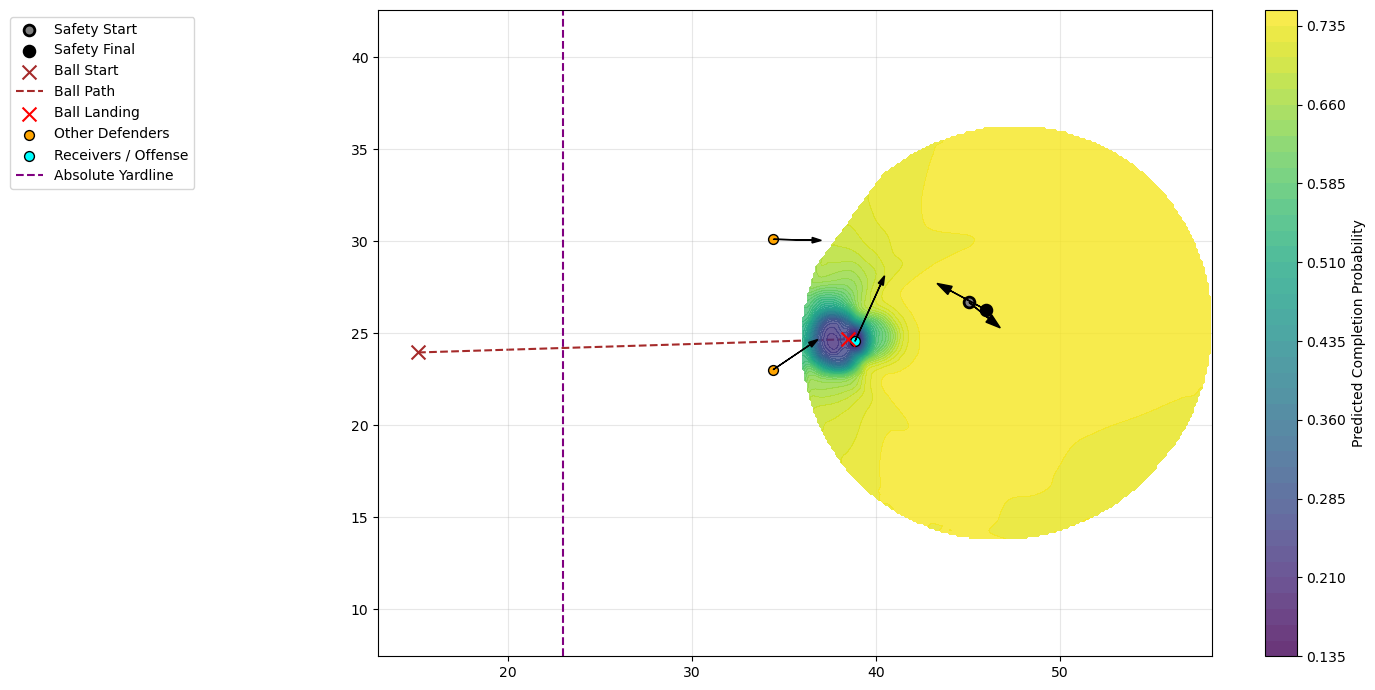

In [21]:
ex_df = cmp_results[cmp_results['gpid'] == gpid]
print(plays.query("gpid == @gpid").play_description.values[0])
plot_safety_reach_heatmap(ex_df, model_type="cmp", tracking=tracking)